# 뉴스 기사 요약봇 만들기

## Step 1. 데이터 수집하기
뉴스 기사 데이터 출처: (https://github.com/sunnysai12345/News_Summary)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import summa
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')

import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
data.sample(10)

,headlines,text
89927,Sushmita shares pics in dress to talk about bo...,Actress Sushmita Sen has shared pictures of he...
12380,Japanese journalist held hostage in Syria free...,Japanese journalist Jumpei Yasuda held hostage...
872,Missing radioactive isotope found in scrapyard...,"A container of radioactive isotope Cs-137, whi..."
90303,Telangana allots 1000 sq yd plot to PV Sindhu ...,"The Telangana government has allotted a 1,000 ..."
32021,Rahane's omission from ODI squad harsh decisio...,Former India captain Sourav Ganguly has said t...
12879,I've become star but I don't want to believe i...,Ayushmann Khurrana said he knows he has become...
7347,Don't want to react: Priyanka on article calli...,"Priyanka Chopra, on being asked about the arti..."
25491,"Dhoni carries ball after series loss, sparks r...",Former Team India captain MS Dhoni was spotted...
29243,50% ownership of Domino's Pizza was once trade...,Domino's Pizza Co-founder James Monaghan in 19...
17119,Vodafone & Idea come together to create IndiaÃ...,Vodafone India and Idea Cellular have come tog...


In [5]:
len(data)

98401

## Step 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플과 Null 값 제거하기

In [6]:
print('headlines 열에서 중복 배제한 샘플 수: ',data['headlines'].nunique())
print('text 열에서 중복 배제한 샘플 수: ',data['text'].nunique())

headlines 열에서 중복 배제한 샘플 수:  98280
text 열에서 중복 배제한 샘플 수:  98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('text 열에서 중복 제외한 전체 샘플 수: ', len(data))

text 열에서 중복 제외한 전체 샘플 수:  98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))


# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 정하기

텍스트의 최소 길이: 1
텍스트의 최대 길이: 60
텍스트의 평균 길이: 35.09968483123221
헤드라인의 최소 길이: 1
헤드라인의 최대 길이: 16
헤드라인의 평균 길이: 9.299532330215534


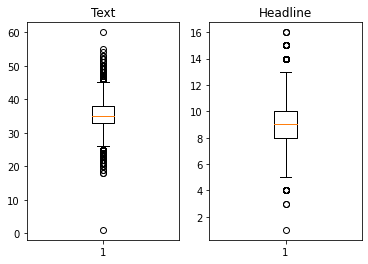

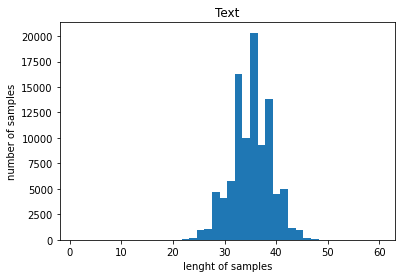

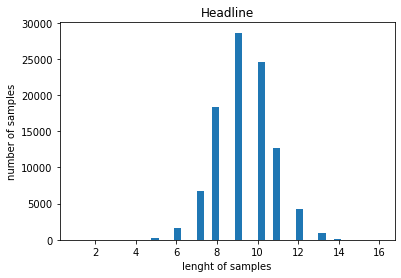

In [15]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이: {}'.format(np.min(text_len)))
print('텍스트의 최대 길이: {}'.format(np.max(text_len)))
print('텍스트의 평균 길이: {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이: {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이: {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이: {}'.format(np.mean(headline_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')

plt.subplot(1, 2, 2)
plt.boxplot(headline_len)
plt.title('Headline')
# plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 50
headline_max_len = 16

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [19]:
data['text_sample'] = data['text'].apply(lambda x: True if len(x.split()) <= text_max_len else False)

print(data['text_sample'].value_counts())

cond = data['text_sample'] == False
data = data.drop(data[cond].index, axis=0)

print('전체 샘플 수: ', len(data))

True     98346
False       14
Name: text_sample, dtype: int64
전체 샘플 수:  98346


In [20]:
data.drop('text_sample', axis=1, inplace=True)

In [21]:
cond = data['text'].apply(lambda x: False if len(x.split()) > 1 else True)
data.drop(data[cond].index, axis=0, inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98345


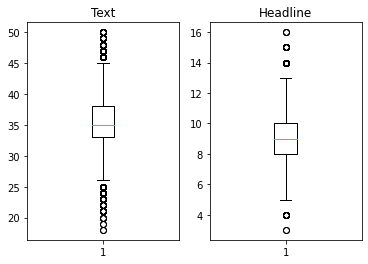

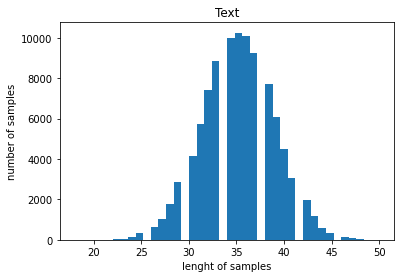

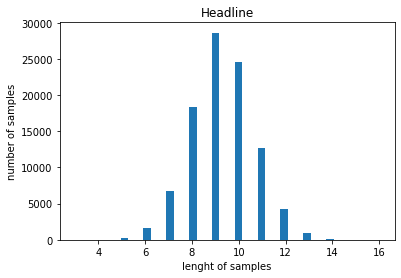

In [22]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('Text')

plt.subplot(1, 2, 2)
plt.boxplot(headline_len)
plt.title('Headline')
# plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('lenght of samples')
plt.ylabel('number of samples')
plt.show()

### 시작 토큰과 종료 토큰 추가하기

In [36]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [37]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 훈련 데이터와 테스트 데이터 나누기

In [38]:
from sklearn.model_selection import train_test_split

inputs = pd.concat([data['text'], data['decoder_input']], axis=1, join='inner')
target = data['decoder_target']

inputs.shape, target.shape

((98345, 2), (98345,))

In [39]:
input_train, input_test, target_train, target_test = train_test_split(inputs, target,
                                                                     test_size=0.2)

print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(78676, 2)
(19669, 2)
(78676,)
(19669,)


In [40]:
input_train.head()

,text,decoder_input
34416,technology giant apple reportedly planning lau...,sostoken iphone se to launch in may without he...
78504,clown motel united states nevada listed sale d...,sostoken clown motel goes on sale for nearly c...
38550,convicted gangster abu salem lodged mumbai jai...,sostoken bored reading newspaper in jail need ...
94078,players fought pitch match brazilian football ...,sostoken players fight on pitch after goalkeep...
13760,australian cricketer john hastings revealed ev...,sostoken been coughing up blood when bowl aust...


In [41]:
target_train.head()

34416    iphone se to launch in may without headphone j...
78504    clown motel goes on sale for nearly crore eost...
38550    bored reading newspaper in jail need someone t...
94078    players fight on pitch after goalkeeper kicks ...
13760    been coughing up blood when bowl australian cr...
Name: decoder_target, dtype: object

In [42]:
encoder_input_train = np.array(input_train['text'])
decoder_input_train = np.array(input_train['decoder_input'])
decoder_target_train = np.array(target_train)

encoder_input_test = np.array(input_test['text'])
decoder_input_test = np.array(input_test['decoder_input'])
decoder_target_test = np.array(target_test)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78676
훈련 레이블의 개수 : 78676
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


### 정수 인코딩

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(encoder_input_train)

In [52]:
threshold = 7
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69663
등장 빈도가 6번 이하인 희귀 단어의 수: 47487
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22176
단어 집합에서 희귀 단어의 비율: 68.16674561819043
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4854914255331786


In [54]:
vocab_size = 22000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(encoder_input_train)

In [57]:
encoder_input_train = tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[206, 475, 284, 24, 579, 453, 1005, 2968, 115, 3, 193, 5207, 11532, 2197, 1258, 494, 452, 3041, 1561, 1588, 3650, 2614, 256, 1258, 115, 6, 2727, 1862, 1740, 1005, 2968, 263, 2252, 3436], [10727, 16691, 289, 332, 10982, 1848, 645, 1687, 16691, 39, 1806, 168, 11533, 874, 23, 416, 2368, 11862, 11863, 3001, 1, 274, 25, 2368, 720, 10727, 4116], [1476, 3792, 2940, 9141, 1779, 78, 479, 1363, 5874, 2035, 86, 10728, 2885, 2529, 3762, 43, 1650, 859, 3437, 5875, 326, 1332, 4446, 1558, 9141, 1810, 325, 3256, 479, 161, 59, 108, 36]]


In [58]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [66]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30014
등장 빈도가 3번 이하인 희귀 단어의 수: 16879
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13135
단어 집합에서 희귀 단어의 비율: 56.237089358299464
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1418336764872885


In [67]:
tar_vocab = 13000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 548, 2918, 3, 249, 4, 84, 246, 7682, 1641, 35], [1, 7683, 11642, 379, 7, 365, 5, 1109, 33], [1, 6847, 5019, 2594, 4, 215, 432, 2006, 3, 3260, 4010, 6479], [1, 495, 401, 7, 1429, 11, 4130, 5020, 385, 12, 486], [1, 480, 25, 1053, 243, 4011, 697, 887]]
target
decoder  [[548, 2918, 3, 249, 4, 84, 246, 7682, 1641, 35, 2], [7683, 11642, 379, 7, 365, 5, 1109, 33, 2], [6847, 5019, 2594, 4, 215, 432, 2006, 3, 3260, 4010, 6479, 2], [495, 401, 7, 1429, 11, 4130, 5020, 385, 12, 486, 2], [480, 25, 1053, 243, 4011, 697, 887, 2]]


In [68]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('정수 인코딩 이후 길이가 0이된 훈련 데이터의 개수: ', len(drop_train))
print('정수 인코딩 이후 길이가 0이된 테스트 데이터의 개수: ', len(drop_test))

정수 인코딩 이후 길이가 0이된 훈련 데이터의 개수:  0
정수 인코딩 이후 길이가 0이된 테스트 데이터의 개수:  0


In [71]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기

In [75]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [83]:
# 인코더 설계 시작
embedding_dim = 700
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(vocab_size, embedding_dim, name='encoder_embedding')(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, name='encoder_lstm1')
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, name='encoder_lstm2')
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, name='encoder_lstm3')
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [84]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [85]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax', name='decoder_output')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 50, 700)      15400000    input_4[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 50, 512), (N 2484224     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [86]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 50, 700)      15400000    input_4[0][0]                    
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 50, 512), (N 2484224     encoder_embedding[0][0]          
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [88]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 118s 366ms/step - loss: 4.2780 - val_loss: 3.7985
Epoch 2/50
308/308 [==============================] - 111s 361ms/step - loss: 3.5957 - val_loss: 3.3934
Epoch 3/50
308/308 [==============================] - 111s 361ms/step - loss: 3.2307 - val_loss: 3.1595
Epoch 4/50
308/308 [==============================] - 111s 361ms/step - loss: 2.9636 - val_loss: 3.0136
Epoch 5/50
308/308 [==============================] - 111s 362ms/step - loss: 2.7535 - val_loss: 2.9080
Epoch 6/50
308/308 [==============================] - 112s 363ms/step - loss: 2.5775 - val_loss: 2.8462
Epoch 7/50
308/308 [==============================] - 111s 362ms/step - loss: 2.4254 - val_loss: 2.7973
Epoch 8/50
308/308 [==============================] - 112s 362ms/step - loss: 2.2869 - val_loss: 2.7692
Epoch 9/50
308/308 [==============================] - 112s 362ms/step - loss: 2.1621 - val_loss: 2.7527
Epoch 10/50
308/308 [==============================] - 112s 362m

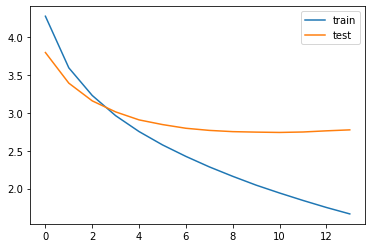

In [89]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [91]:
src_index_to_word = tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [92]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 
# 이전 시점의 상태로 사용. 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [96]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기

In [97]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [98]:
for i in range(10):
    print("원문: ", seq2text(encoder_input_test[i]))
    print("실제 요약: ", seq2headline(decoder_input_test[i]))
    print("예측 요약: ", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('\n')

원문:  sara ali khan debut bollywood film kedarnath opposite sushant singh rajput set release june next year sharing details bollywood trade analyst taran adarsh tweeted film directed abhishek kapoor produced balaji motion pictures kriarj entertainment film shooting expected start later year 
실제 요약:  sara debut film opposite sushant to release in june 
예측 요약:   sara ali khan film to star in kedarnath reports


원문:  petrol price increased first time wednesday since dynamic fuel pricing came effect june indian oil raised price petrol delhi paisa per litre thursday petrol price fallen per litre delhi last days diesel price reduced per litre 
실제 요약:  petrol price rises for the first time since pricing 
예측 요약:   petrol diesel prices hits all time high of per litre


원문:  virat kohli slammed st hundred th odi sunday sachin tendulkar hit first odis sachin scored runs first odis virat scored runs kohli runs hundreds best average odis matches 
실제 요약:  virat kohli has centuries after odis sachin h

test 비교 결과:
* 전반적으로 문법적으로 맞지 않은 문장들이 생성됨
* 전혀 이해할 수 없는 요약 문장이 있는가 하면
* 나름 말이 되는 요약 문장도 있음

실제 요약:  petrol price rises for the first time since pricing   
예측 요약:   petrol diesel prices hits all time high of per litre  

-> 문장 자체는 문법을 따르고 있지 않지만 petrol 가격이 사상 최대를 기록했다는 의미는 나름 담고 있음

## Step 5. Summa를 이용해서 추출적 요약해보기

In [99]:
from summa.summarizer import summarize

In [135]:
test_text = """
A 28-year-old man has tested positive for Middle East Respiratory Syndrome Coronavirus (MERS-CoV) in Abu Dhabi, the World Health Organization said on Monday. Authorities checked 108 people that he was in contact with, but no secondary infections turned up. The WHO said there were no signs the man had come into contact with dromedary camels, which spread the disease.
"""

In [136]:
print('Summary: ', summarize(test_text, words=10))

Summary:  The WHO said there were no signs the man had come into contact with dromedary camels, which spread the disease.


In [137]:
clean_test_text = preprocess_sentence(test_text)
print(clean_test_text)
print('-'*45)
input_test_text = tokenizer.texts_to_sequences(clean_test_text)
print(input_test_text)
print('-'*45)
input_test_text = pad_sequences(input_test_text, maxlen=text_max_len, padding='post')
print(input_test_text)
print('-'*45)

year old man tested positive middle east respiratory syndrome coronavirus abu dhabi world health organization said monday authorities checked people contact secondary infections turned said signs man come contact dromedary camels spread disease
---------------------------------------------
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 

의도한 바: 실제 기사를 가져와서 두가지 요약을 해보고 비교해보고 싶었으나...
문제점
1. 내가 만든 모델은 text_max_len이 50밖에 되지 않은 짧은 문장을 토대로 헤드라인을 뽑는 모델이라면, summa의 summarize는 여러 문장을 가지고 있는 긴 길이의 글을 토대로 중요 문장을 뽑는 방식. 서로에게 적합한 글이 달라 성능을 딱 비교하기 어려웠음
2. tokenizer를 통한 정수인코딩이 새로운 문장에서 잘 기능하지 않는 문제 발생 -> 학습에 쓰인 데이터셋과 내가 긁어온 기사의 단어들이 서로 너무 달라서 그럴 수 있을 것이라 추측... 근데 한 개도 안되는 건 문제가 있지 않나?


In [146]:
df = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
sample_text = df['text'].sample(3)

In [147]:
print(sample_text)

52109    Chinese researchers have proposed using space-...
75385    Amazon on Sunday said it is refunding purchase...
73710    The Delhi government on Wednesday said it has ...
Name: text, dtype: object


In [150]:
for s in sample_text:
    print(s)
    print('summarize: ', summarize(s, words=10))

Chinese researchers have proposed using space-based lasers for breaking large-sized space junk into smaller pieces, claimed to make them potentially less harmful. NASA estimates over 7.5 lakh pieces of old satellite and rocket debris smaller than 1 cm exist in Earth's orbit. However, only 22,000 are tracked, travelling at speeds above 27,000 kmph which can harm satellites and manned missions.
summarize:  NASA estimates over 7.5 lakh pieces of old satellite and rocket debris smaller than 1 cm exist in Earth's orbit.
Amazon on Sunday said it is refunding purchases of solar eclipse glasses in the US that are below safety standards needed to protect users' eyes. Amazon is warning customers to not use the glasses ahead of the upcoming eclipse on 21st August across the US. Amazon is also recalling some glasses that do not come from recommended manufacturers. 
summarize:  Amazon is warning customers to not use the glasses ahead of the upcoming eclipse on 21st August across the US.
The Delhi g

In [151]:
clean_test_text = []
for s in sample_text:
    clean_test_text.append(preprocess_sentence(s))
print(clean_test_text)
input_test_text = tokenizer.texts_to_sequences(clean_test_text)
print(input_test_text)
input_test_text = pad_sequences(input_test_text, maxlen=text_max_len, padding='post')
print(input_test_text)

['chinese researchers proposed using space based lasers breaking large sized space junk smaller pieces claimed make potentially less harmful nasa estimates lakh pieces old satellite rocket debris smaller cm exist earth orbit however tracked travelling speeds kmph harm satellites manned missions', 'amazon sunday said refunding purchases solar eclipse glasses us safety standards needed protect users eyes amazon warning customers use glasses ahead upcoming eclipse st august across us amazon also recalling glasses come recommended manufacturers', 'delhi government wednesday said seized nearly kilograms plastic bags thinner microns two weeks national green tribunal banned nearly lakh collected environment compensation government added plastic manufacturers claimed delhi would get rid least plastic ban imposed strictly']
[[269, 232, 706, 154, 306, 36, 11591, 2037, 1215, 4269, 306, 12739, 3728, 3616, 40, 117, 5142, 774, 5183, 609, 5819, 64, 3616, 13, 1560, 1474, 4918, 3728, 77, 4482, 511, 289

In [152]:
for i, s in enumerate(sample_text):
    print("원문: ", s)
    print("추출적 요약: ", summarize(s, words=10))
    print("추상적 요약: ", decode_sequence(input_test_text[i].reshape(1, text_max_len)))

원문:  Chinese researchers have proposed using space-based lasers for breaking large-sized space junk into smaller pieces, claimed to make them potentially less harmful. NASA estimates over 7.5 lakh pieces of old satellite and rocket debris smaller than 1 cm exist in Earth's orbit. However, only 22,000 are tracked, travelling at speeds above 27,000 kmph which can harm satellites and manned missions.
추출적 요약:  NASA estimates over 7.5 lakh pieces of old satellite and rocket debris smaller than 1 cm exist in Earth's orbit.
추상적 요약:   scientists to use earth as iss lab made earth
원문:  Amazon on Sunday said it is refunding purchases of solar eclipse glasses in the US that are below safety standards needed to protect users' eyes. Amazon is warning customers to not use the glasses ahead of the upcoming eclipse on 21st August across the US. Amazon is also recalling some glasses that do not come from recommended manufacturers. 
추출적 요약:  Amazon is warning customers to not use the glasses ahead of th

In [153]:
sample_text = df['text'].sample(3)

In [155]:
for i, s in enumerate(sample_text):
    print("원문: ", s)
    print("추출적 요약: ", summarize(s, words=7))
    print("추상적 요약: ", decode_sequence(input_test_text[i].reshape(1, text_max_len)))

원문:  Two jailed Nationalist Congress Party MLAs, Chhagan Bhujbal and Ramesh Kadam, cast their votes in the Presidential elections on Monday, a Vidhan Bhawan official said. While Bhujbal had received permission from a Special Court to vote in the elections, the Bombay High Court had allowed Kadam to vote.
추출적 요약:  
추상적 요약:   scientists to use earth as iss lab made earth
원문:  Mukesh Ambani-led Reliance Industries plans to raise about Ã¢ÂÂ¹40,000 crore in debt during FY19 as it expands its consumer businesses, according to reports. Reliance's total debt has reportedly tripled in the past five years. The company has total borrowings of about Ã¢ÂÂ¹2.2 trillion, more than half of which is due to be repaid by 2022, according to Bloomberg. 
추출적 요약:  
추상적 요약:   amazon to use solar eclipse to make solar eclipse
원문:  DD spinner Sandeep Lamichhane on Saturday became the first cricketer from Nepal to play in the IPL. Lamichhane, aged 17 years and 283 days, dismissed RCB's Parthiv Patel to become 